In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math
import datetime
import dateutil.parser
import time
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
from tqdm import tqdm_notebook
pd.options.mode.chained_assignment = None

## Step 1: import data for party vote shares and ideological positions ##

In [3]:
# Dataframe containing party vote shares in 2011-14 and 2015-18 election cycles
party_stats_df = pd.read_csv("source_data/parlgov_party_vote_shares.csv",encoding="cp1252")
party_stats_df.dropna(subset=["latest_election_share"],inplace=True)
party_stats_df = party_stats_df[~((party_stats_df["previous_election_share"] == 0) & (party_stats_df["latest_election_share"] == 0))]
party_stats_df["vote_share_change"] = party_stats_df["latest_election_share"] - party_stats_df["previous_election_share"]
party_stats_df

,country,party_id,party_abbrev,party_name_english,previous_election_date,previous_election_source,previous_election_share,previous_election_notes,previous_election_total_votes,previous_election_party_votes,latest_election,latest_election_source,latest_election_share,latest_election_notes,last_election_total_votes,last_election_party_votes
0,Belgium,102,PS,Socialist Party\tParti Socialiste,2014,http://www.parlgov.org/explore/BEL/election/20...,11.7,NaN,6744547,789112,NaN,NaN,NaN,NaN,NaN,NaN
1,Belgium,103,SPA,Socialist Party Different\tSocialistische Part...,2014,http://www.parlgov.org/explore/BEL/election/20...,8.8,NaN,6744547,593520,NaN,NaN,NaN,NaN,NaN,NaN
2,Belgium,104,ECOLO,Ecolo\tEcolo,2014,http://www.parlgov.org/explore/BEL/election/20...,3.3,NaN,6744547,222570,NaN,NaN,NaN,NaN,NaN,NaN
3,Belgium,105,Groen,Green\tGroen,2014,http://www.parlgov.org/explore/BEL/election/20...,5.3,NaN,6744547,357461,NaN,NaN,NaN,NaN,NaN,NaN
4,Belgium,106,MR,Reformist Movement\tMouvement Réformateur,2014,http://www.parlgov.org/explore/BEL/election/20...,9.6,NaN,6744547,647477,NaN,NaN,NaN,NaN,NaN,NaN
5,Belgium,107,VLD,Open Flemish Liberals and Democrats\tOpen Vlaa...,2014,http://www.parlgov.org/explore/BEL/election/20...,9.8,NaN,6744547,660966,NaN,NaN,NaN,NaN,NaN,NaN
6,Belgium,108,cdH,Humanist Democratic Centre\tCentre Démocrate H...,2014,http://www.parlgov.org/explore/BEL/election/20...,5.0,NaN,6744547,337227,NaN,NaN,NaN,NaN,NaN,NaN
7,Belgium,109,CD&V,Christian Democratic and Flemish\tChristen-Dem...,2014,http://www.parlgov.org/explore/BEL/election/20...,11.6,NaN,6744547,782367,NaN,NaN,NaN,NaN,NaN,NaN
8,Belgium,110,N-VA,New Flemish Alliance\tNieuw-Vlaamse Alliantie,2014,http://www.parlgov.org/explore/BEL/election/20...,20.3,NaN,6744547,1369143,NaN,NaN,NaN,NaN,NaN,NaN
9,Belgium,111,FDF,Francophone Democratic Federalists\tFédéralist...,2014,http://www.parlgov.org/explore/BEL/election/20...,1.8,NaN,6744547,121402,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Dataframe containing party ideological ratings from Chapel-Hill Expert Survey
party_CHES_2014_df = pd.read_csv("source_data/CHES_2014_party_ideological_ratings.csv")
party_CHES_2017_df = pd.read_csv("source_data/CHES_2017_party_ideological_ratings.csv")

In [6]:
# Transform CHES rating on European integration, so that 0 = strongly in favour, 10 = strongly opposed
party_CHES_2014_df["EU_integration"] = 10 - (party_CHES_2014_df["eu_position"] - 1) * (10/6)
party_CHES_2017_df["EU_integration"] = 10 - (party_CHES_2017_df["position"] - 1) * (10/6)

## Step 2: join CHES ratings onto vote share dataframe, and export

In [31]:
# CHES metrics to use for the analysis
metric_names = ["antielite_salience","EU_integration","immigrate_policy","galtan","lrecon"]

In [14]:
# Function that joins CHES ratings to party dataframe
def get_metric_info(metric):
    
    global party_stats_df
    
    metric_2014_list = []
    for i in party_stats_df["party_id"]:
        try:
            if int(i) in list(party_CHES_2014_df["party_id"]):
                metric_2014_list.append(party_CHES_2014_df[party_CHES_2014_df["party_id"]==i][metric].iloc[0])
            elif int(i) in list(party_CHES_2017_df["party_id"]):
                metric_2014_list.append(party_CHES_2017_df[party_CHES_2017_df["party_id"]==i][metric].iloc[0])
        except Exception:
            metric_2014_list.append(5.0)

    party_stats_df[metric+"_2014"] = metric_2014_list
                
    metric_2017_list = []
    for i in party_stats_df["party_id"]:
        try:
            if int(i) in list(party_CHES_2017_df["party_id"]):
                metric_2017_list.append(party_CHES_2017_df[party_CHES_2017_df["party_id"]==i][metric].iloc[0])
            elif int(i) in list(party_CHES_2014_df["party_id"]):
                metric_2017_list.append(party_CHES_2014_df[party_CHES_2014_df["party_id"]==i][metric].iloc[0])
        except Exception:
            metric_2017_list.append(5.0)

    party_stats_df[metric+"_2017"] = metric_2017_list

In [15]:
for m in metric_names:
    get_metric_info(m)

In [16]:
# Export merged dataframe
party_stats_df.to_csv("output_data/party_stats_df.csv")

## Step 2: explore relationships between ideological positions and votes gained

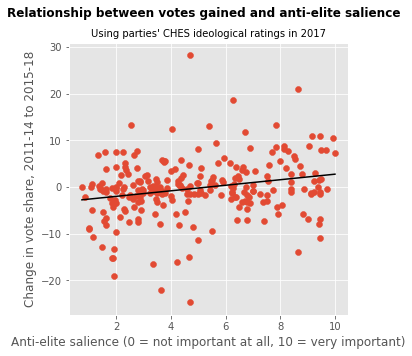

In [47]:
fig,ax = plt.subplots(figsize=(5,5))
plt.suptitle("Relationship between votes gained and anti-elite salience",size=12,weight="bold")
plt.title("Using parties' CHES ideological ratings in 2017",size=10)
x = party_stats_df["antielite_salience_2017"]
y = party_stats_df["vote_share_change"]
ax.scatter(x,y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color="black")
ax.set_xlabel("Anti-elite salience (0 = not important at all, 10 = very important)")
ax.set_ylabel("Change in vote share, 2011-14 to 2015-18")
plt.show()

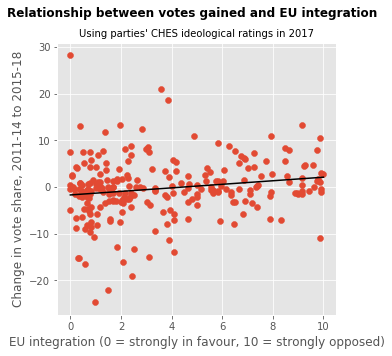

In [48]:
fig,ax = plt.subplots(figsize=(5,5))
plt.suptitle("Relationship between votes gained and EU integration",size=12,weight="bold")
plt.title("Using parties' CHES ideological ratings in 2017",size=10)
x = party_stats_df["EU_integration_2017"]
y = party_stats_df["vote_share_change"]
ax.scatter(x,y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color="black")
ax.set_xlabel("EU integration (0 = strongly in favour, 10 = strongly opposed)")
ax.set_ylabel("Change in vote share, 2011-14 to 2015-18")
plt.show()

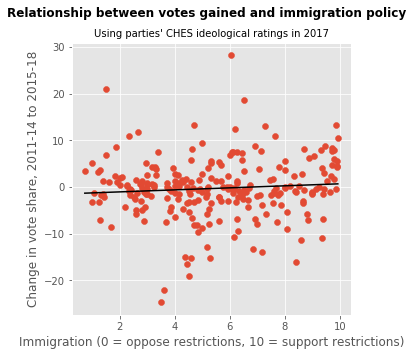

In [49]:
fig,ax = plt.subplots(figsize=(5,5))
plt.suptitle("Relationship between votes gained and immigration policy",size=12,weight="bold")
plt.title("Using parties' CHES ideological ratings in 2017",size=10)
x = party_stats_df["immigrate_policy_2017"]
y = party_stats_df["vote_share_change"]
ax.scatter(x,y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color="black")
ax.set_xlabel("Immigration (0 = oppose restrictions, 10 = support restrictions)")
ax.set_ylabel("Change in vote share, 2011-14 to 2015-18")
plt.show()

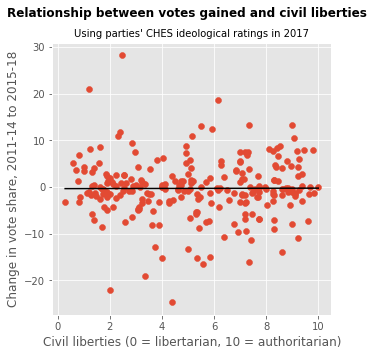

In [50]:
fig,ax = plt.subplots(figsize=(5,5))
plt.suptitle("Relationship between votes gained and civil liberties",size=12,weight="bold")
plt.title("Using parties' CHES ideological ratings in 2017",size=10)
x = party_stats_df["galtan_2017"]
y = party_stats_df["vote_share_change"]
ax.scatter(x,y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color="black")
ax.set_xlabel("Civil liberties (0 = libertarian, 10 = authoritarian)")
ax.set_ylabel("Change in vote share, 2011-14 to 2015-18")
plt.show()

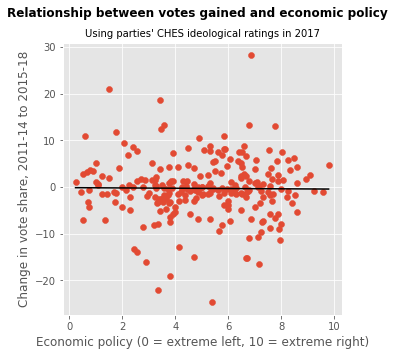

In [51]:
fig,ax = plt.subplots(figsize=(5,5))
plt.suptitle("Relationship between votes gained and economic policy",size=12,weight="bold")
plt.title("Using parties' CHES ideological ratings in 2017",size=10)
x = party_stats_df["lrecon_2017"]
y = party_stats_df["vote_share_change"]
ax.scatter(x,y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color="black")
ax.set_xlabel("Economic policy (0 = extreme left, 10 = extreme right)")
ax.set_ylabel("Change in vote share, 2011-14 to 2015-18")
plt.show()